# Transactions - Data Integration

In [121]:
import os

import joblib
import pandas as pd
import matplotlib.pyplot as plt

from helpers import (
    CHARTS_DIR, ENCODER_MODEL_DIR, RAW_DATA_DIR, TRANSFORMED_DATA_DIR
)

## Load imputed data and decode encoding

In [2]:
encoder_path = ENCODER_MODEL_DIR / 'one_hot_encoder_township_building_type_tenure.joblib'

if os.path.exists(encoder_path):
    ohe = joblib.load(encoder_path)
else:
    raise Exception(f'Encoder not found at {encoder_path}')

In [5]:
df_imputed = pd.read_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt5_multi_imputed_bayesianridge.parquet')
df_imputed_inverse = ohe.inverse_transform(df_imputed.drop(columns=['price_psf', 'price']))
df_imputed_inverse

,township,building_type,tenure,floors,rooms,land_area,built_up,year,month,day
0,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,2.893189,2196.0,1130.011500,2023.0,6.0,9.0
1,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.079764,753.0,1272.862928,2023.0,6.0,1.0
2,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,3.232031,3197.0,1521.765384,2023.0,5.0,29.0
3,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.091576,753.0,1256.558519,2023.0,5.0,25.0
4,BANDAR BARU SRI PETALING,SEMI-D,LEASEHOLD,2.5,3.837520,4801.0,2202.912522,2023.0,5.0,22.0
...,...,...,...,...,...,...,...,...,...,...
265265,HERITAGE STATION HOTEL,FLAT,LEASEHOLD,1.0,2.000000,493.0,493.000000,1990.0,11.0,13.0
265266,IDAMAN PUTERI,CONDOMINIUM,FREEHOLD,1.0,3.000000,1454.0,1454.000000,2005.0,1.0,10.0
265267,KELAB LE CHATEAU II,CONDOMINIUM,FREEHOLD,1.0,3.000000,593.0,593.000000,2008.0,2.0,25.0
265268,MUTIARA SENTUL CONDOMINIUM,APARTMENT,LEASEHOLD,1.0,2.000000,1193.0,1193.000000,2009.0,8.0,10.0


In [7]:
df_imputed = pd.concat([df_imputed_inverse, df_imputed[['price_psf', 'price']]], axis=1)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265270 entries, 0 to 265269
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   township       265270 non-null  category
 1   building_type  265270 non-null  category
 2   tenure         265270 non-null  category
 3   floors         265270 non-null  float64 
 4   rooms          265270 non-null  float64 
 5   land_area      265270 non-null  float64 
 6   built_up       265270 non-null  float64 
 7   year           265270 non-null  float64 
 8   month          265270 non-null  float64 
 9   day            265270 non-null  float64 
 10  price_psf      265270 non-null  float64 
 11  price          265270 non-null  float64 
dtypes: category(3), float64(9)
memory usage: 19.3 MB


In [8]:
type_conversion = {
    'township': 'category',
    'building_type': 'category',
    'tenure': 'category',
    'floors': 'int',
    'rooms': 'int',
    'land_area': 'float',
    'built_up': 'float',
    'price_psf': 'float',
    'price': 'float',
    'year': 'int',
    'month': 'int',
    'day': 'int'
}

for column, dtype in type_conversion.items():
    df_imputed[column] = df_imputed[column].astype(dtype)

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265270 entries, 0 to 265269
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   township       265270 non-null  category
 1   building_type  265270 non-null  category
 2   tenure         265270 non-null  category
 3   floors         265270 non-null  int32   
 4   rooms          265270 non-null  int32   
 5   land_area      265270 non-null  float64 
 6   built_up       265270 non-null  float64 
 7   year           265270 non-null  int32   
 8   month          265270 non-null  int32   
 9   day            265270 non-null  int32   
 10  price_psf      265270 non-null  float64 
 11  price          265270 non-null  float64 
dtypes: category(3), float64(4), int32(5)
memory usage: 14.2 MB


## Load and visualise economic indicators for integration

### Overnight Policy Rate (OPR) / Interest Rates

Source:
1. Bank Negara Malaysia: https://www.bnm.gov.my/monetary-stability/opr-decisions
2. Reuters: https://www.reuters.com/article/malaysia-economy-rates-idINKLR43945120090224

In [9]:
df_opr = pd.read_excel(RAW_DATA_DIR / 'bnm-opr_historical-1998-2023.xlsx')
df_opr['date'] = pd.to_datetime(df_opr['date'])
df_opr.head()

,date,opr_change_percentage,new_opr_percentage
0,2023-07-06,0,3.00
1,2023-05-03,+0.25,3.00
2,2023-03-09,0,2.75
3,2023-01-19,0,2.75
4,2022-11-03,+0.25,2.75


<Axes: title={'center': 'Historical Overnight Policy Rate (OPR) from 1998 to 2023'}, xlabel='date'>

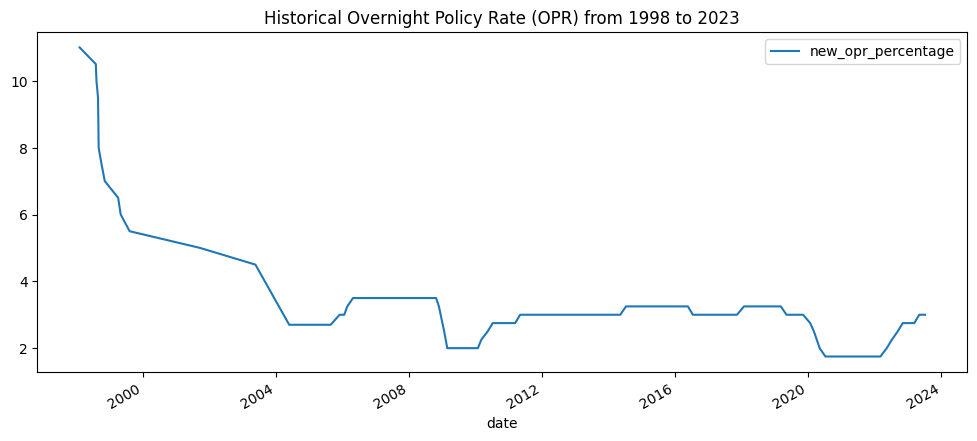

In [10]:
df_opr.sort_values(by='date').plot(
    x='date',
    y='new_opr_percentage',
    figsize=(8,6),
    title='Historical Overnight Policy Rate (OPR) from 1998 to 2023'
)

### Consumer Price Index

In [11]:
df_annual_cpi = pd.read_excel(RAW_DATA_DIR / 'wb-annual-cpi-1960-2022.xlsx', sheet_name='Data', skiprows=3)
df_annual_cpi = df_annual_cpi.query("`Country Name` == 'Malaysia'").drop(columns=['Country Name', 'Country Code', 'Indicator Code']).T
df_annual_cpi = df_annual_cpi.iloc[1:].reset_index()
df_annual_cpi.columns = ['year', 'Consumer price index (2010 = 100)']
df_annual_cpi = df_annual_cpi.astype({'year': 'int', 'Consumer price index (2010 = 100)': 'float'})
df_annual_cpi.head()

,year,Consumer price index (2010 = 100)
0,1960,21.309241
1,1961,21.270798
2,1962,21.293864
3,1963,21.955092
4,1964,21.866672


In [12]:
df_monthly_cpi = pd.read_csv(RAW_DATA_DIR / 'dosm-monthly-cpi-2010-2023.csv')
df_monthly_cpi['date'] = pd.to_datetime(df_monthly_cpi['date'])
df_monthly_cpi.tail()

,date,overall,food_beverage,alcohol_tobacco,clothing_footwear,housing_utilities,furnishings,health,transport,communication,recreation_culture,education,hospitality,misc
158,2023-03-01,129.9,151.3,170.9,93.5,124.7,125.3,127.5,120.0,96.1,116.3,124.1,146.2,120.9
159,2023-04-01,130.0,151.1,171.0,93.5,124.7,125.3,127.5,120.4,96.1,116.7,124.3,146.0,121.4
160,2023-05-01,130.2,151.8,171.1,93.5,125.3,125.5,127.6,120.2,93.9,117.1,124.6,146.9,121.9
161,2023-06-01,130.4,151.9,171.1,93.4,125.3,125.5,127.9,120.5,94.0,117.4,124.7,147.1,122.1
162,2023-07-01,130.5,152.5,171.1,93.5,125.3,125.7,128.2,120.6,93.9,117.1,124.9,147.6,122.0


In [13]:
mean_cpi_2023 = df_monthly_cpi.query("'2021-01-01' <= date <= '2021-12-31'")['overall'].mean()
mean_cpi_2023

123.075

In [14]:
df_annual_cpi.loc[len(df_annual_cpi)] = [2023, mean_cpi_2023]
df_annual_cpi.tail()

,year,Consumer price index (2010 = 100)
59,2019.0,121.463089
60,2020.0,120.079987
61,2021.0,123.054491
62,2022.0,127.212131
63,2023.0,123.075000


<Axes: title={'center': 'Malaysia Consumer Price Index from 1960 to 2023 (2010 = 100)'}, xlabel='Year', ylabel='CPI (2010 = 100)'>

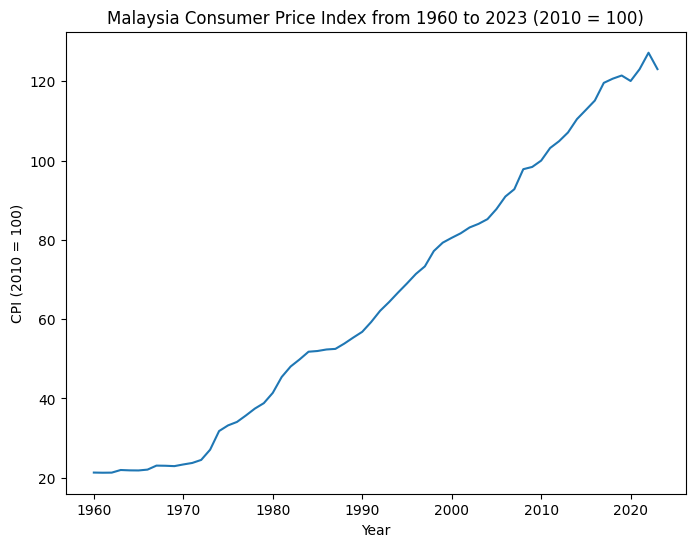

In [108]:
df_annual_cpi.plot(
    x='year',
    y='Consumer price index (2010 = 100)',
    figsize=(8,6),
    title='Malaysia Consumer Price Index from 1960 to 2023 (2010 = 100)',
    legend=False,
    xlabel='Year',
    ylabel='CPI (2010 = 100)'
)

In [16]:
df_income = pd.read_csv(RAW_DATA_DIR / 'dosm-households_and_income_by_state-1984-2022.csv')
df_income = df_income.query("state == 'W.P. Kuala Lumpur'").reset_index(drop=True)
df_income['year'] = pd.to_datetime(df_income['date']).dt.year
df_income['n_households'] = df_income['n_households'] * 1000
df_income.head()

,date,state,n_households,median,mean,gini,year
0,1970-01-01,W.P. Kuala Lumpur,NaN,NaN,NaN,NaN,1970
1,1974-01-01,W.P. Kuala Lumpur,NaN,NaN,NaN,NaN,1974
2,1976-01-01,W.P. Kuala Lumpur,NaN,NaN,1058.0,NaN,1976
3,1979-01-01,W.P. Kuala Lumpur,NaN,NaN,NaN,NaN,1979
4,1984-01-01,W.P. Kuala Lumpur,NaN,NaN,1920.0,0.4856,1984


<Axes: title={'center': 'Household Income in Kuala Lumpur from 1984 to 2022'}, xlabel='year'>

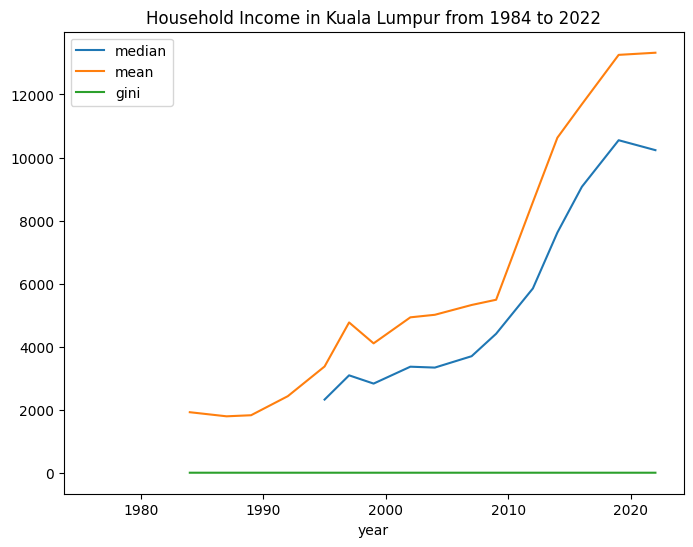

In [109]:
df_income.plot(
    x='year',
    y=['median', 'mean', 'gini'],
    figsize=(8,6),
    title='Household Income in Kuala Lumpur from 1984 to 2022'
)

<Axes: title={'center': 'Number of Households in Kuala Lumpur from 1984 to 2022'}, xlabel='year'>

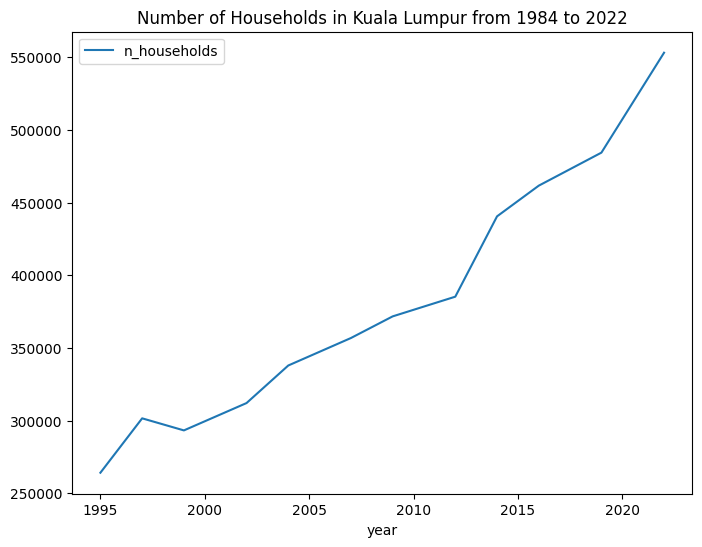

In [111]:
df_income.plot(
    x='year',
    y='n_households',
    figsize=(8,6),
    title='Number of Households in Kuala Lumpur from 1984 to 2022'
)

In [112]:
df_wellbeing = pd.read_csv(RAW_DATA_DIR / 'dosm-malaysian_wellbeing_index-2000-2021.csv')
df_wellbeing.head()

,Component,Sub Component,Year,Index
0,Economic Well-being,Total,2000,100.0
1,Economic Well-being,Total,2001,100.2
2,Economic Well-being,Total,2002,101.5
3,Economic Well-being,Total,2003,104.2
4,Economic Well-being,Total,2004,105.8


<Axes: title={'center': 'Malaysian Well-being Index from 2000 to 2021'}, xlabel='Year', ylabel='Wellbeing Index'>

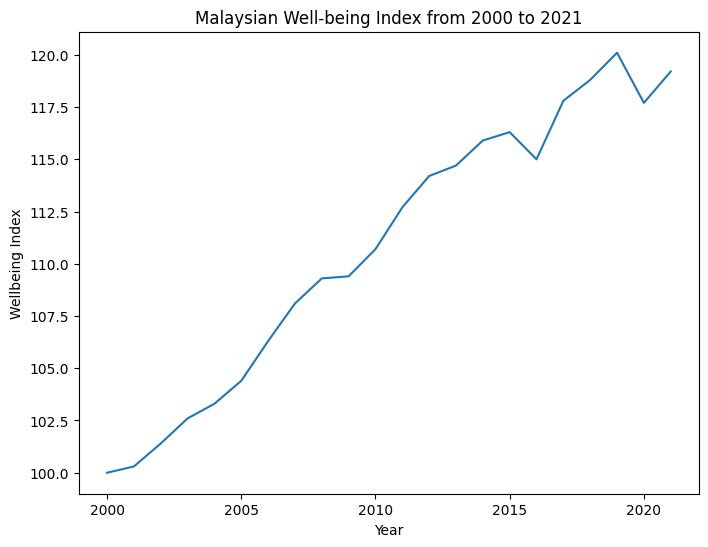

In [113]:
df_wellbeing = df_wellbeing.query("`Component` == 'Malaysian Well-being Index'")
df_wellbeing.plot(
    x='Year',
    y='Index',
    figsize=(8,6),
    title='Malaysian Well-being Index from 2000 to 2021',
    legend=False,
    xlabel='Year',
    ylabel='Wellbeing Index'
)

### Money Supply (M3)

Source:
1. DOSM: https://archive.data.gov.my/data/ms_MY/dataset/total-money-supply
2. BNM: https://www.bnm.gov.my/publications/mhs

In [114]:
df_money = pd.read_csv(RAW_DATA_DIR / 'dosm-total_money_supply-2000-2023.csv')
df_money = df_money.query("`Monetary Aggregat` == 'M3'")
df_money.head()

,Year,Monetary Aggregat,Money Supply,Category,RM Million
72,2000,M3,Broad money supply,n.a.,458363.1
73,2001,M3,Broad money supply,n.a.,471730.5
74,2002,M3,Broad money supply,n.a.,504150.2
75,2003,M3,Broad money supply,n.a.,553058.4
76,2004,M3,Broad money supply,n.a.,621225.8


<Axes: title={'center': 'Malaysia Total Money Supply (M3) from 2000 to 2023'}, xlabel='Year', ylabel='RM Million'>

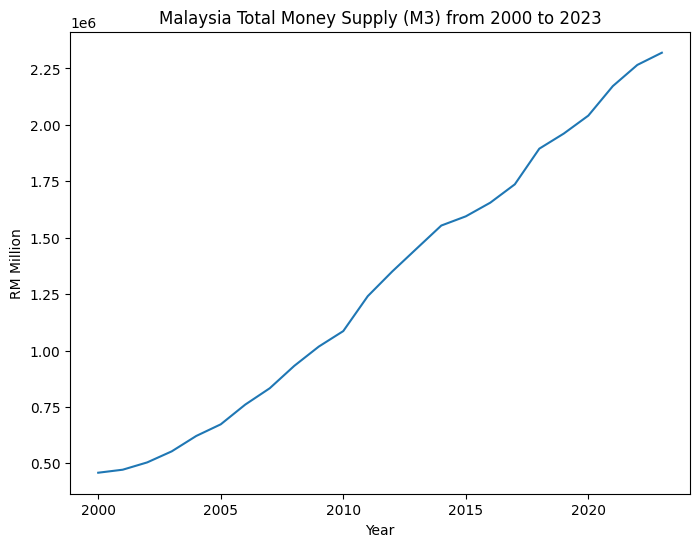

In [106]:
df_money.plot(
    x='Year', 
    y='RM Million', 
    figsize=(8,6),
    title='Malaysia Total Money Supply (M3) from 2000 to 2023',
    legend=False,
    xlabel='Year',
    ylabel='RM Million'
)

### Unemployment Rate

Source:
1. Annual data - DOSM: https://data.gov.my/data-catalogue/labour_labourforce_annual_5
2. Monthly data - DOSM: https://data.gov.my/data-catalogue/labour_labourforce_monthly_5

In [23]:
df_unemployment = pd.read_csv(RAW_DATA_DIR / 'dosm-unemployment_rate-1982-2023.csv')
df_unemployment['date'] = pd.to_datetime(df_unemployment['date'])
df_unemployment['year'] = df_unemployment['date'].dt.year
df_unemployment.head()

,date,lf_size,employed,unemployed,outside,u_rate,p_rate,ep_ratio,year
0,1982-01-01,5431.4,5249.0,182.4,2944.6,3.4,64.8,62.67,1982
1,1983-01-01,5671.8,5457.0,214.9,2969.4,3.8,65.6,63.15,1983
2,1984-01-01,5862.5,5566.7,295.8,3119.6,5.0,65.3,61.98,1984
3,1985-01-01,5990.1,5653.4,336.8,3124.9,5.6,65.7,62.02,1985
4,1986-01-01,6222.1,5760.1,461.9,3188.3,7.4,66.1,61.21,1986


<Axes: title={'center': 'Unemployment Rate in Malaysia from 1982 to 2023'}, xlabel='Year', ylabel='Unemployment Rate (%)'>

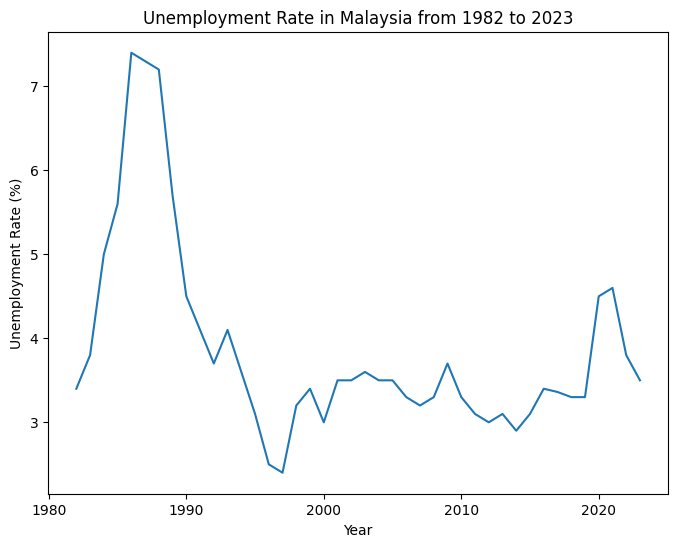

In [105]:
df_unemployment.plot(
    x='year',
    y='u_rate',
    figsize=(8,6),
    title='Unemployment Rate in Malaysia from 1982 to 2023',
    legend=False,
    xlabel='Year',
    ylabel='Unemployment Rate (%)'
)

### Population

Source:
1. Population by state 1980-2020 - DOSM: https://archive.data.gov.my/data/ms_MY/dataset/population-by-age-sex-and-ethnic-group-wp-kuala-lumpur
2. Population by state 2020-2023 - DOSM: https://open.dosm.gov.my/data-catalogue/population_population_state_0?state=w.p.-kuala-lumpur

In [25]:
df_population = pd.read_excel(RAW_DATA_DIR / 'dosm-population_KL-2000-2023.xlsx', skiprows=1)
df_population = df_population.rename(columns={
    'Unnamed: 0': 'Year',
    'Unnamed: 1': 'State',
    'Female': "Female ('000)",
    'Male': "Male ('000)",
    'Total': "Total ('000)"
})
df_population.head()

,Year,State,Administrative District,Female ('000),Male ('000),Total ('000)
0,2000,W.P. Kuala Lumpur,N.A,695.8,720.2,1416.0
1,2001,W.P. Kuala Lumpur,N.A,710.1,736.1,1446.2
2,2002,W.P. Kuala Lumpur,N.A,723.5,750.6,1474.1
3,2003,W.P. Kuala Lumpur,N.A,735.9,764.6,1500.5
4,2004,W.P. Kuala Lumpur,N.A,748.3,778.1,1526.4


<Axes: title={'center': "Population in Kuala Lumpur from 2000 to 2023 ('000)"}, xlabel='Year'>

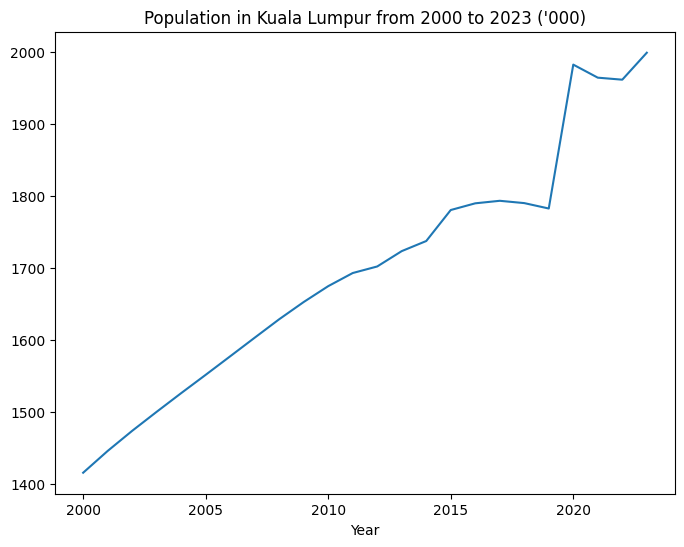

In [116]:
df_population.plot(
    x='Year', 
    y="Total ('000)", 
    figsize=(8,6),
    title="Population in Kuala Lumpur from 2000 to 2023 ('000)",
    legend=False,
)

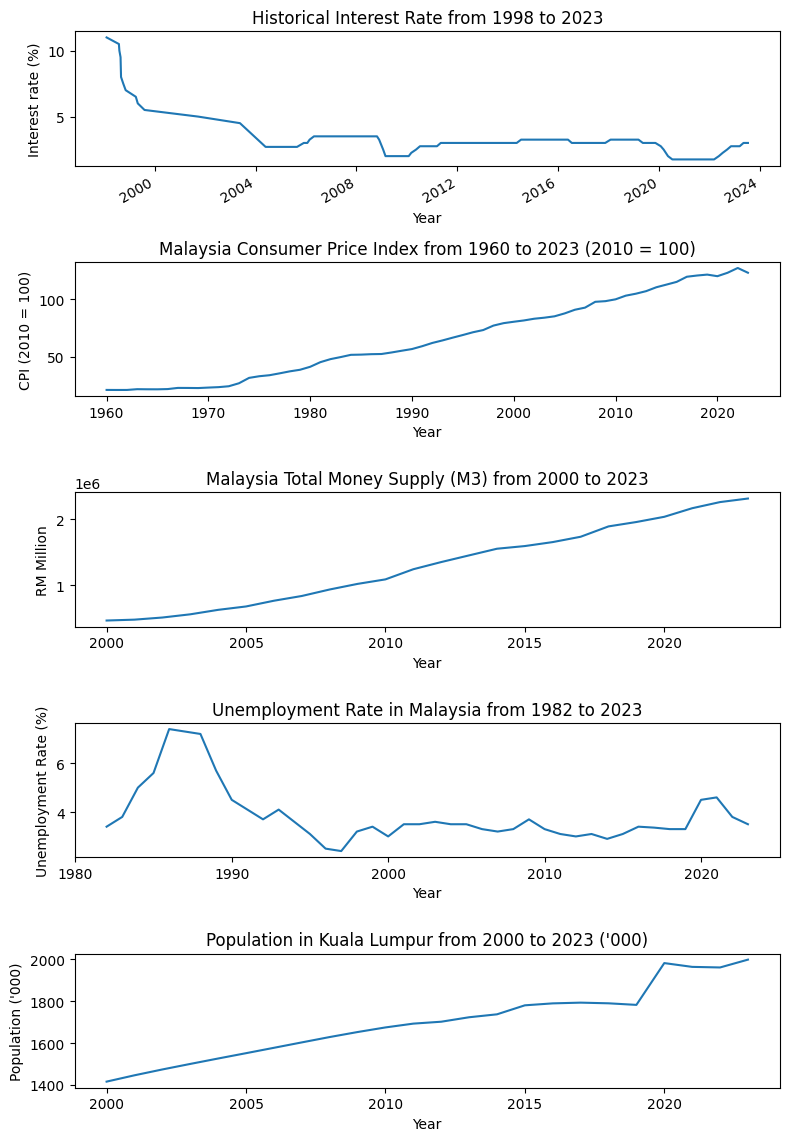

In [134]:
fig, axes = plt.subplots(nrows=5, figsize=(8, 12))
# fig.suptitle('Economic Indicators without Missing Values')

df_opr.sort_values(by='date').plot(
    x='date',
    y='new_opr_percentage',
    title='Historical Interest Rate from 1998 to 2023',
    legend=False,
    xlabel='Year',
    ylabel='Interest rate (%)',
    ax=axes[0]
)

df_annual_cpi.plot(
    x='year',
    y='Consumer price index (2010 = 100)',
    title='Malaysia Consumer Price Index from 1960 to 2023 (2010 = 100)',
    legend=False,
    xlabel='Year',
    ylabel='CPI (2010 = 100)',
    ax=axes[1]
)

df_money.plot(
    x='Year', 
    y='RM Million', 
    title='Malaysia Total Money Supply (M3) from 2000 to 2023',
    legend=False,
    xlabel='Year',
    ylabel='RM Million',
    ax=axes[2]
)

df_unemployment.plot(
    x='year',
    y='u_rate',
    title='Unemployment Rate in Malaysia from 1982 to 2023',
    legend=False,
    xlabel='Year',
    ylabel='Unemployment Rate (%)',
    ax=axes[3]
)

df_population.plot(
    x='Year', 
    y="Total ('000)", 
    title="Population in Kuala Lumpur from 2000 to 2023 ('000)",
    legend=False,
    xlabel='Year',
    ylabel="Population ('000)",
    ax=axes[4]
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

### Household Income and Number of Households

Source:
1. DOSM
2. Free Malaysia Today: https://www.freemalaysiatoday.com/category/nation/2023/07/28/average-income-per-household-up-2-4-to-rm8489/

Require forecasting for 2022 and 2023 of number of households.

### Well-being Index

Require forecasting for 2022 and 2023.

### Crime Rate

Source:
1. Violent crime by contingent, PDRM district and type of crime - DOSM: https://archive.data.gov.my/data/ms_MY/dataset/violent-crime-by-contingent-pdrm-district-and-type-of-crime-malaysia

In [27]:
df_crime = pd.read_csv(RAW_DATA_DIR / 'dosm-number_of_crime_by_state-2015-2021.csv')
df_crime = df_crime.query("`State` == 'W.P. Kuala Lumpur'").reset_index(drop=True)
df_crime = df_crime.groupby('Year').sum().reset_index()
df_crime = df_crime.drop(columns=['State', 'Contingent PDRM District', 'Type of Crime'])
df_crime

,Year,Number of Crime
0,2015,3646
1,2016,3201
2,2017,3372
3,2018,2837
4,2019,2891
5,2020,1937
6,2021,1450


<Axes: title={'center': 'Number of Crime in Kuala Lumpur from 2015 to 2021'}, xlabel='Year'>

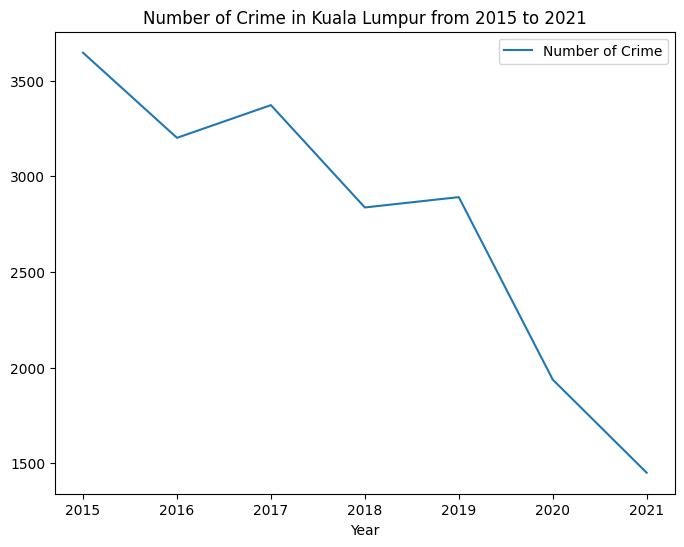

In [120]:
df_crime.plot(
    x='Year',
    y='Number of Crime', 
    figsize=(8,6),
    title='Number of Crime in Kuala Lumpur from 2015 to 2021'
)

### Choosing a data period for the study
The data period of the economic indicators:
- BNM OPR: 1998-2023
- DOSM CPI: 1960-2023
- DOSM household income: 1984-2022
- DOSM number of households: 1984-2022
- DOSM wellbeing index: 2000-2021
- DOSM total money supply: 2000-2023
- DOSM unemployment rate: 1982-2023
- DOSM population: 2000-2023
- DOSM crime rate: 2015-2021

The data period of economic indicators are not consistent. Although the transaction data period starts from 1909 and it is also good to have a longer data period, the economic indicators are not available for the whole period. Thus a start year and end year must be selected. Number of transactions from 1957 to 2020 is 247,541 while the number of transactions from 2000 to 2020 is 28,648. The data from 2000 to 2020 takes up 86% of the data from 1957 to 2020, which is an acceptable range given that the economic indicators are mostly in 2000s.

Combined with the significance of the Millennia (Year 2000), the data period of the economic indicators will be limited to 2000-2020. The prediction period will be 2021-2023.

Let's check if there are 24 data points for each indicator (2000-2023).

## Missing data in economic indicators

In addition, some economic indicators are not recorded on yearly basis. Some are only recorded once in a few years, which we need to interpolate and extrapolate.

In [29]:
def check_data_period_length(df: pd.DataFrame, column_name: str):
    target_data_period = {x for x in range(2000, 2023 + 1)}
    try:
        assert df[column_name].dtype in ['int', 'float'], 'Column must be numeric type'
        period_length = df.query(f'{column_name} >= 2000')[column_name].value_counts().sort_index()
        assert len(period_length) == 2023 - 2000 + 1, 'Did not get 24 years of data'
        print('Data period length is correct, we have data from 2000-2023')
    except AssertionError as e:
        print(e)
        missing_years = target_data_period - set(period_length.index)
        print(f'Missing years: {sorted(missing_years)}')

In [30]:
df_opr['year'] = df_opr['date'].dt.year

check_data_period_length(df_opr, 'year')

Did not get 24 years of data
Missing years: [2000, 2002]


There are missing years e.g. 2000 and 2002, which we need to extrapolate (2000) and interpolate (2002).

In [31]:
check_data_period_length(df_annual_cpi, 'year')

Data period length is correct, we have data from 2000-2023


We have the adequate data and correct number of data points.

In [32]:
for col in ['median', 'mean', 'n_households']:
    print(col)
    check_data_period_length(df_income[['year', col]], 'year')

median
Did not get 24 years of data
Missing years: [2000, 2001, 2003, 2005, 2006, 2008, 2010, 2011, 2013, 2015, 2017, 2018, 2020, 2021, 2023]
mean
Did not get 24 years of data
Missing years: [2000, 2001, 2003, 2005, 2006, 2008, 2010, 2011, 2013, 2015, 2017, 2018, 2020, 2021, 2023]
n_households
Did not get 24 years of data
Missing years: [2000, 2001, 2003, 2005, 2006, 2008, 2010, 2011, 2013, 2015, 2017, 2018, 2020, 2021, 2023]


There are missing years for 2000, 2001, 2003, 2005, 2006, 2008, 2010, 2011, 2013, 2015, 2017, 2018, 2020, 2021, 2023.

In [33]:
df_wellbeing = df_wellbeing.astype({'Year': 'int', 'Index': 'float'})
check_data_period_length(df_wellbeing, 'Year')

Did not get 24 years of data
Missing years: [2022, 2023]


There are missing years for 2022 and 2023.

In [34]:
df_money = df_money.astype({'Year': 'int', 'RM Million': 'float'})
check_data_period_length(df_money, 'Year')

Data period length is correct, we have data from 2000-2023


No missing years for money supply (M3).

In [35]:
check_data_period_length(df_unemployment, 'year')

Data period length is correct, we have data from 2000-2023


No missing years for unemployment rate.

In [36]:
df_population = df_population.astype({'Year': 'int', "Total ('000)": 'float'})
check_data_period_length(df_population, 'Year')

Data period length is correct, we have data from 2000-2023


No missing years for population.

In [37]:
df_crime = df_crime.astype({'Year': 'int', 'Number of Crime': 'float'})
check_data_period_length(df_crime, 'Year')

Did not get 24 years of data
Missing years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2022, 2023]


There are missing years for 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2022, 2023.

Thus, the values of the following economic indicators will need to be forecasted:
1. Median household income: 2023
2. Mean household income: 2023
3. Number of households: 2023
4. Wellbeing index: 2022-2023
5. Crime rate: 2022-2023

and backcasted:
1. Crime rate: 2000-2014

and interpolated:
1. OPR: 2000, 2002
2. Median household income: 2000, 2001, 2003, 2005, 2006, 2008, 2010, 2011, 2013, 2015, 2017, 2018, 2020, 2021, 2023
3. Mean household income: 2000, 2001, 2003, 2005, 2006, 2008, 2010, 2011, 2013, 2015, 2017, 2018, 2020, 2021, 2023
4. Number of households: 2000, 2001, 2003, 2005, 2006, 2008, 2010, 2011, 2013, 2015, 2017, 2018, 2020, 2021, 2023

## Extrapolating and backcasting economic indicators

Due to the insufficient data period of the economic indicators, the data will need to be extrapolated, as noted in the United Nation's working paper titled "A weighted extrapolation method for measuring the SDGs progress" (Nia, 2017). Based on discovered literature, there are two main methods:
1. Time-weighted extrapolation (Nia, 2017)
2. Spline extrapolation (International Monetary Fund, 2023)

In this study, we use the time-weighted extrapolation as proposed by Nia (2017), despite the Spline extrapolation being used in the Malaysian context by IMF in the 2023 press release. The reasons are:
1. The press release did not specify the implementation details of the Spline extrapolation, which makes it difficult to replicate the results.
2. In the press release, it was stated that, quote "We applied Spline extrapolation to quarterly data to obtain monthly figures.". However, using quarterly data (sparser) to obtain monthly figures (less sparse than quarterly data) is interpolation, instead.
3. Based on Scipy documentation, extrapolation is not fully supported, thus it is difficult to replicate the results.
4. Nia (2017) included its implementation details in the working paper, which makes it easier to replicate the results.

Based on Nia (2017), the best extrapolation method were identified, using voting system, for each of the indicator with missing data:
1. Number of households: Log-transformed regression
2. Wellbeing index: Time-weighted log-transformed regression
3. Crime rate: Time-weighted geometric mean

### Forecasting
There are multiple methods for forecasting the economic indicators. The procedures for each extrapolation method are as detailed below.

#### Log-transformed Regression
1. The indicator I is converted to Y by dividing it by an appropriate scale to standardize it to a scale of 0 to 1.
    - Indicators shown in percentage are divided by 100 and indicators expressed in other rates such as “per 1000”, “per 100,000” divided accordingly by 1000 and 100,000. For some indicators that cannot be expressed in the form of probability or rate, no transformation is applied.
2. A natural log transformation is applied to indicators that needed transformation in the Step 1.
3. Normalise each year by subtracting the mean year.
4. Fit a linear regression model to the transformed data.
5. Obtain the slope, intercept and standard error from the fitted model.
6. Use the slope and intercept to extrapolate the indicator.

##### Log-transformed Regression: Number of Households

In [38]:
df_households = df_income[['year', 'n_households']]
df_households = df_households.dropna().reset_index(drop=True)
df_households

,year,n_households
0,1995,264200.0
1,1997,301600.0
2,1999,293300.0
3,2002,312100.0
4,2004,337930.0
5,2007,356818.0
6,2009,371702.0
7,2012,385249.0
8,2014,440480.0
9,2016,461600.0


In [39]:
# Log-transformed Regression
# Step 1 and 2 omitted as the data is not expressed in the form of probability or rate
# Step 3: Normalise each year
mean_year = df_households['year'].mean()
df_households['norm_year'] = df_households['year'] - mean_year

from scipy.stats import linregress

# Step 4 and 5: Calculate the slope and intercept of the linear regression line
slope, intercept, rvalue, pvalue, stderr = linregress(df_households['norm_year'], df_households['n_households'])
print(f'Slope: {slope}')
print(f'Intercept: {intercept}')
print(f'R-squared: {rvalue}')
print(f'P-value: {pvalue}')
print(f'Stderr: {stderr}')

# Step 6: Extrapolate the number of households for 2023
target_year = 2023
number_of_households_extrapolated = round(slope * (target_year - df_households['year'].mean()) + intercept)
print(f'Number of households in {target_year}: {number_of_households_extrapolated}')

df_households_extrapolated = pd.concat([df_households[['year', 'n_households']], pd.DataFrame({'year': [target_year], 'n_households': [number_of_households_extrapolated]})])
df_households_extrapolated

Slope: 9725.687645687643
Intercept: 380189.9166666667
R-squared: 0.975926321569147
P-value: 6.115858095261981e-08
Stderr: 687.32143289867
Number of households in 2023: 526075


,year,n_households
0,1995,264200.0
1,1997,301600.0
2,1999,293300.0
3,2002,312100.0
4,2004,337930.0
5,2007,356818.0
6,2009,371702.0
7,2012,385249.0
8,2014,440480.0
9,2016,461600.0


<Axes: title={'center': 'Number of Households in Kuala Lumpur from 1984 to 2023'}, xlabel='year'>

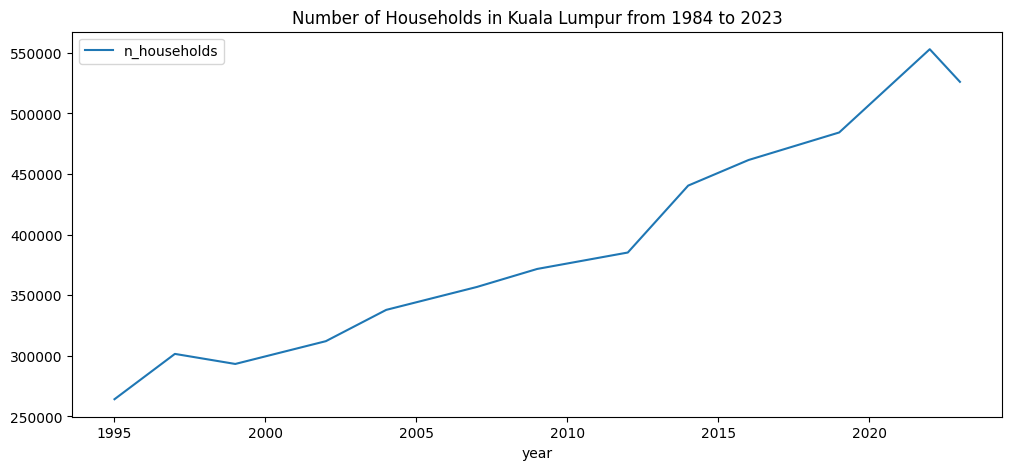

In [41]:
df_households_extrapolated.plot(
    x='year',
    y='n_households',
    figsize=(8,6),
    title='Number of Households in Kuala Lumpur from 1984 to 2023'
)

The number of household dropped, whereas the trend has been on the rise since 2000. Therefore, we try to use the time-weighted log-transformed regression to forecast the number of households.

#### Time-weighted Log-transformed Regression
1. The indicator I is converted to Y by dividing it by an appropriate scale to standardize it to a scale of 0 to 1.
    - Indicators shown in percentage are divided by 100 and indicators expressed in other rates such as “per 1000”, “per 100,000” divided accordingly by 1000 and 100,000. For some indicators that cannot be expressed in the form of probability or rate, no transformation is applied.
2. A natural log transformation is applied to indicators that needed transformation in the Step 1.
3. Compute the corresponding weights for each observation. 
4. Sum all the weights.
5. Normalise each year by subtracting the mean year.
6. Compute the slope using weights from Step 1 and 2, and the normalised year in Step 3.
7. Use the time-weighted slope and intercept from normal log-transformed regression to extrapolate the indicator.

##### Time-weighted Log-transformed Regression: Number of Households

In [70]:
# Time-weighted Log-transformed Regression
# Step 1 and 2 omitted as the data is not expressed in the form of probability or rate
# Step 3: Compute corresponding weights for each observation

df_households['weights'] = (target_year - df_households['year'][0]) / (target_year - df_households['year'])

# Step 4: Sum the weights
sum_of_weights = df_households['weights'].sum()

# Step 5: Normalise each year
mean_year = df_households['year'].mean()
df_households['norm_year'] = df_households['year'] - mean_year

# Step 6: Calculate the slope and intercept of the linear regression line
df_households['wtL'] = df_households['weights'] * df_households['norm_year'] * df_households['n_households']
df_households['wt'] = df_households['weights'] * df_households['norm_year']
df_households['wL'] = df_households['weights'] * df_households['n_households']
df_households['wt2'] = df_households['weights'] * df_households['norm_year'] ** 2

term1 = df_households['wtL'].sum()
term2 = df_households['wt'].sum() * df_households['wL'].sum() / sum_of_weights
term3 = df_households['wt2'].sum()
term4 = df_households['wt'].sum() ** 2 / sum_of_weights

weighted_slope = (term1 - term2) / (term3 - term4)
print(f'Weighted slope: {weighted_slope}')

# Step 7: Extrapolate the number of households for 2023
number_of_households_extrapolated = round(weighted_slope * (target_year - mean_year) + intercept)
print(f'Number of households in 2023: {number_of_households_extrapolated}')

df_households['legend'] = 'Actual'

df_households_extrapolated = pd.concat([
    df_households[['year', 'n_households', 'legend']], 
    pd.DataFrame({'year': [target_year], 'n_households': [number_of_households_extrapolated], 'legend': 'Extrapolated'})
])
df_households_extrapolated

Weighted slope: 11605.519672809882
Number of households in 2023: 554273


,year,n_households,legend
0,1995,264200.0,Actual
1,1997,301600.0,Actual
2,1999,293300.0,Actual
3,2002,312100.0,Actual
4,2004,337930.0,Actual
5,2007,356818.0,Actual
6,2009,371702.0,Actual
7,2012,385249.0,Actual
8,2014,440480.0,Actual
9,2016,461600.0,Actual


<Axes: title={'center': 'Number of Households in Kuala Lumpur from 1984 to 2023'}, xlabel='Year', ylabel='Number of Households'>

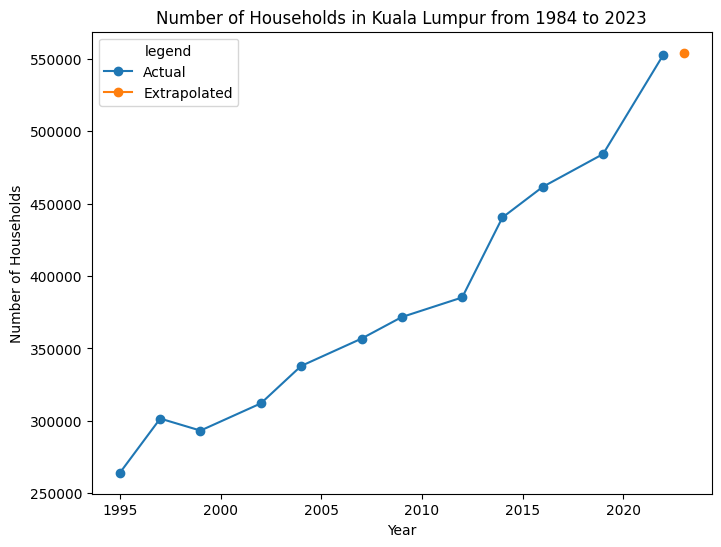

In [71]:
df_households_extrapolated.pivot(index='year', columns='legend', values='n_households').plot(
    marker='o',
    linestyle='-',
    figsize=(8,6),
    title='Number of Households in Kuala Lumpur from 1984 to 2023',
    xlabel='Year',
    ylabel='Number of Households'
)

The time-weighted regression method made more sense. We will use this method for all extrapolations. 

Let's make a function which takes in the dataframe and the target years, then output the extrapolated dataframe.

In [74]:
def extrapolate_economic_indicators(df_input: pd.DataFrame, target_years: list, time_variable: str, to_extrapolate: str, continuous: bool):
    # Time-input Log-transformed Regression
    # Step 1 and 2 omitted as the data is not expressed in the form of probability or rate
    # Step 3: Compute corresponding weights for each observation

    output = []

    for target_year in target_years:
        df_input['weights'] = (target_year - df_input[time_variable][0]) / (target_year - df_input[time_variable])

        # Step 4: Sum the weights
        sum_of_weights = df_input['weights'].sum()

        # Step 5: Normalise each year
        mean_year = df_input[time_variable].mean()
        df_input['norm_year'] = df_input[time_variable] - mean_year

        # Step 6: Calculate the slope and intercept of the linear regression line
        df_input['wtL'] = df_input['weights'] * df_input['norm_year'] * df_input[to_extrapolate]
        df_input['wt'] = df_input['weights'] * df_input['norm_year']
        df_input['wL'] = df_input['weights'] * df_input[to_extrapolate]
        df_input['wt2'] = df_input['weights'] * df_input['norm_year'] ** 2

        term1 = df_input['wtL'].sum()
        term2 = df_input['wt'].sum() * df_input['wL'].sum() / sum_of_weights
        term3 = df_input['wt2'].sum()
        term4 = df_input['wt'].sum() ** 2 / sum_of_weights

        input_slope = (term1 - term2) / (term3 - term4)

        _, intercept, _, _, _ = linregress(df_input['norm_year'], df_input[to_extrapolate])

        # Step 7: Extrapolate
        if continuous:
            extrapolated_number = input_slope * (target_year - mean_year) + intercept
        else:
            extrapolated_number = round(input_slope * (target_year - mean_year) + intercept)
        print(f'{to_extrapolate} in {target_year}: {extrapolated_number}')

        output.append([target_year, extrapolated_number, 'Extrapolated'])

    df_input['legend'] = 'Actual'

    df_output = df_input[[time_variable, to_extrapolate, 'legend']]
    df_output = pd.concat([df_output, pd.DataFrame(output, columns=[time_variable, to_extrapolate, 'legend'])], ignore_index=True)
    return df_output

##### Time-weighted Log-transformed Regression: Median Household Income

median in 2023: 10762.874385830582


<Axes: title={'center': 'Median Income in Kuala Lumpur from 1984 to 2023'}, xlabel='Year', ylabel='Median Income'>

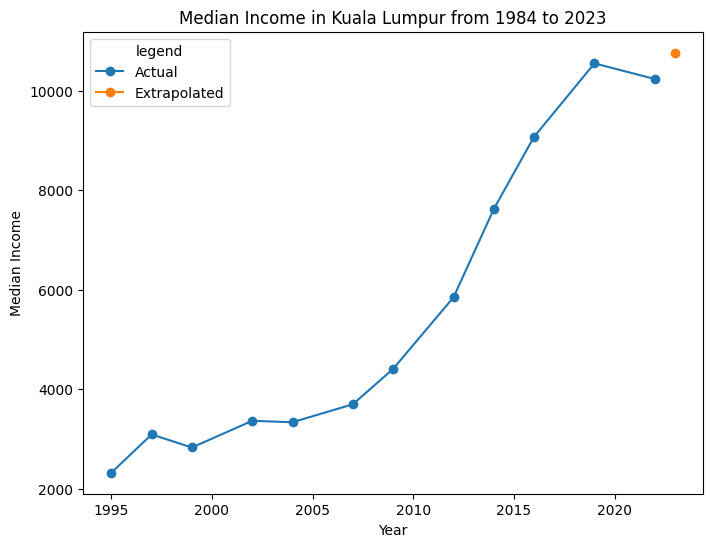

In [77]:
df_median_income_extrapolated = df_income[['year', 'median']]
df_median_income_extrapolated = df_median_income_extrapolated.dropna().reset_index(drop=True)

df_median_income_extrapolated = extrapolate_economic_indicators(df_median_income_extrapolated, [2023], 'year', 'median', True)
df_median_income_extrapolated.pivot(index='year', columns='legend', values='median').plot(
    marker='o',
    linestyle='-',
    figsize=(8,6),
    title='Median Income in Kuala Lumpur from 1984 to 2023',
    xlabel='Year',
    ylabel='Median Income'
)

##### Time-weighted Log-transformed Regression: Mean Household Income

mean in 2023: 13613.61161019724


<Axes: title={'center': 'Mean Income in Kuala Lumpur from 1984 to 2023'}, xlabel='Year', ylabel='Mean Income'>

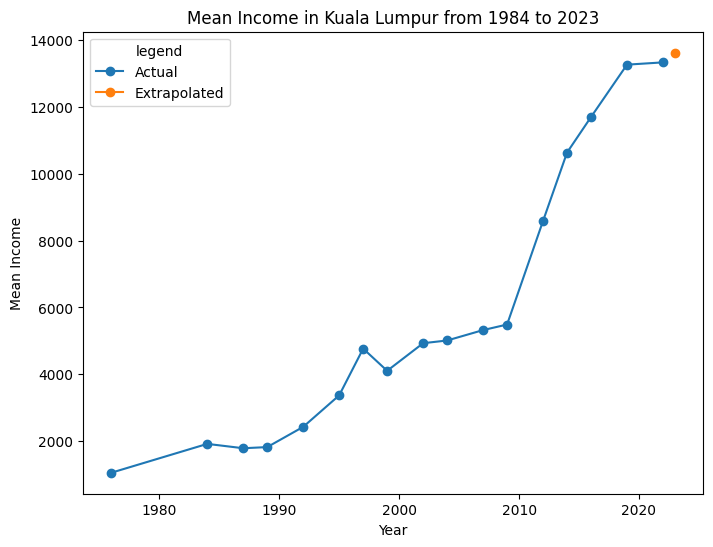

In [80]:
df_mean_income_extrapolated = df_income[['year', 'mean']]
df_mean_income_extrapolated = df_mean_income_extrapolated.dropna().reset_index(drop=True)

df_mean_income_extrapolated = extrapolate_economic_indicators(df_mean_income_extrapolated, [2023], 'year', 'mean', True)
df_mean_income_extrapolated.pivot(index='year', columns='legend', values='mean').plot(
    marker='o',
    linestyle='-',
    figsize=(8,6),
    title='Mean Income in Kuala Lumpur from 1984 to 2023',
    xlabel='Year',
    ylabel='Mean Income'
)

In [81]:
df_income_extrapolated = pd.merge(df_median_income_extrapolated, df_mean_income_extrapolated, on='year')
df_income_extrapolated = pd.merge(df_income_extrapolated, df_households_extrapolated, on='year')
df_income_extrapolated

,year,median,legend_x,mean,legend_y,n_households,legend
0,1995,2321.000000,Actual,3371.01000,Actual,264200.0,Actual
1,1997,3090.000000,Actual,4768.00000,Actual,301600.0,Actual
2,1999,2828.000000,Actual,4104.61000,Actual,293300.0,Actual
3,2002,3364.000000,Actual,4930.00000,Actual,312100.0,Actual
4,2004,3336.000000,Actual,5011.00000,Actual,337930.0,Actual
5,2007,3697.000000,Actual,5322.00000,Actual,356818.0,Actual
6,2009,4409.000000,Actual,5488.00000,Actual,371702.0,Actual
7,2012,5847.000000,Actual,8586.00000,Actual,385249.0,Actual
8,2014,7620.000000,Actual,10629.00000,Actual,440480.0,Actual
9,2016,9073.000000,Actual,11692.00000,Actual,461600.0,Actual


In [82]:
df_income_extrapolated.to_parquet(TRANSFORMED_DATA_DIR / 'household_income_extrapolated.parquet')

##### Time-weighted Log-transformed Regression: Well-being Index

Index in 2022: 120.92339025630854
Index in 2023: 122.15118172530468


<Axes: title={'center': 'Malaysian Well-being Index from 2000 to 2023'}, xlabel='Year', ylabel='Wellbeing Index'>

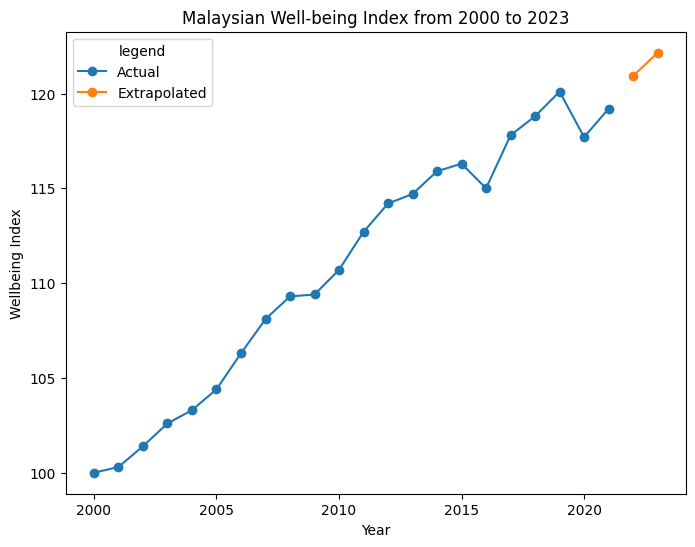

In [84]:
df_wellbeing_extrapolated = df_wellbeing[['Year', 'Index']]
df_wellbeing_extrapolated = df_wellbeing_extrapolated.dropna().reset_index(drop=True)

df_wellbeing_extrapolated = extrapolate_economic_indicators(df_wellbeing_extrapolated, [2022, 2023], 'Year', 'Index', True)
df_wellbeing_extrapolated.pivot(index='Year', columns='legend', values='Index').plot(
    marker='o',
    linestyle='-',
    figsize=(8,6),
    title='Malaysian Well-being Index from 2000 to 2023',
    xlabel='Year',
    ylabel='Wellbeing Index'
)

In [117]:
df_wellbeing_extrapolated.to_parquet(TRANSFORMED_DATA_DIR / 'wellbeing_index_extrapolated.parquet')

##### Time-weighted Log-transformed Regression: Crime Rate

Number of Crime in 2022: 1171
Number of Crime in 2023: 846


<Axes: title={'center': 'Number of Crimes from 2015 to 2023'}, xlabel='Year', ylabel='Number of Crimes'>

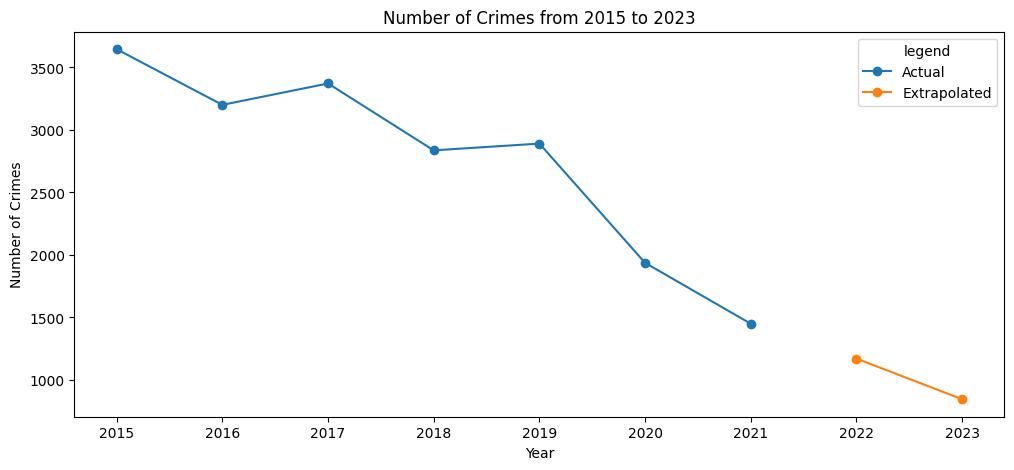

In [85]:
df_crime_extrapolated = df_crime[['Year', 'Number of Crime']]
df_crime_extrapolated = df_crime_extrapolated.dropna().reset_index(drop=True)

df_crime_extrapolated = extrapolate_economic_indicators(df_crime_extrapolated, [2022, 2023], 'Year', 'Number of Crime', False)
df_crime_extrapolated.pivot(index='Year', columns='legend', values='Number of Crime').plot(
    marker='o',
    linestyle='-',
    figsize=(8,6),
    title='Number of Crimes from 2015 to 2023',
    xlabel='Year',
    ylabel='Number of Crimes'
)

However, this extrapolation method could only be used for extrapolating future values. For extrapolating past values, we need to use the backcasting approach.

### Backcasting

Proposed by Hyndman & Athanasoupolos, backcasting can be performed by inversing the data series (also suggested by Stats StackExchange and StackOverflow forums) and forecast the "past values" using time series forecasting methods.

References:
- Hyndman & Athanasoupolos: https://otexts.com/fpp2/backcasting.html
- Stat StackExchange: https://stats.stackexchange.com/questions/190807/regression-on-default-data-and-backward-extrapolation
- StackOverflow: https://stackoverflow.com/questions/70768142/backcast-time-series-using-python

Number of Crime in 2000: 8770
Number of Crime in 2001: 8427
Number of Crime in 2002: 8085
Number of Crime in 2003: 7742
Number of Crime in 2004: 7400
Number of Crime in 2005: 7057
Number of Crime in 2006: 6715
Number of Crime in 2007: 6373
Number of Crime in 2008: 6031
Number of Crime in 2009: 5688
Number of Crime in 2010: 5346
Number of Crime in 2011: 5004
Number of Crime in 2012: 4662
Number of Crime in 2013: 4321
Number of Crime in 2014: 3980


<Axes: title={'center': 'Number of Crimes in Kuala Lumpur from 2000 to 2014'}, xlabel='Year', ylabel='Number of Crimes'>

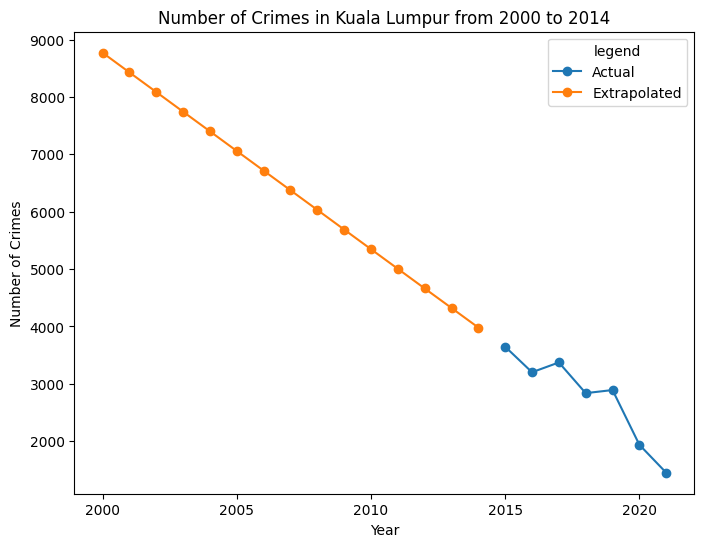

In [118]:
df_crime_reversed = df_crime[['Year', 'Number of Crime']].sort_index(ascending=False, ignore_index=True)

df_crime_backcasted = extrapolate_economic_indicators(df_crime_reversed, [i for i in range(2000, 2015)], 'Year', 'Number of Crime', False)
df_crime_backcasted.pivot(index='Year', columns='legend', values='Number of Crime').plot(
    marker='o',
    linestyle='-',
    figsize=(8,6),
    title='Number of Crimes in Kuala Lumpur from 2000 to 2014',
    xlabel='Year',
    ylabel='Number of Crimes'
)

Then we combine the backcasted and extrapolated data.

<Axes: title={'center': 'Number of Crimes in Kuala Lumpur from 2000 to 2023'}, xlabel='Year', ylabel='Number of Crimes'>

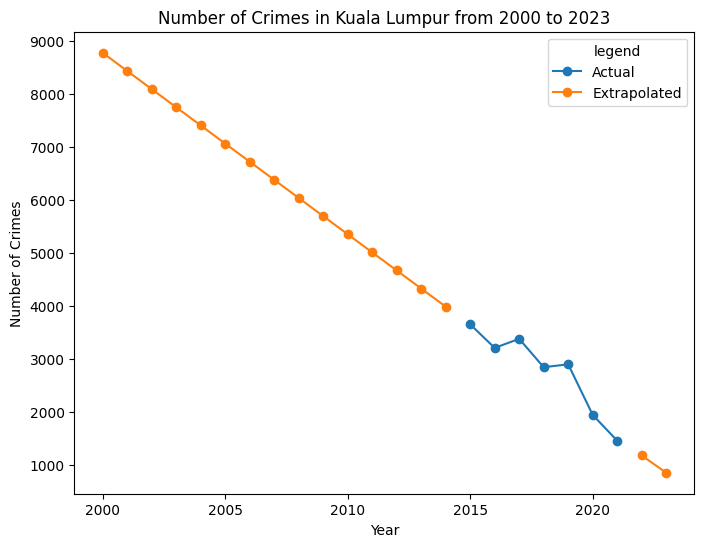

In [119]:
df_crime_combined = pd.concat([df_crime_backcasted, df_crime_extrapolated], ignore_index=True)
df_crime_combined = df_crime_combined.drop_duplicates()
df_crime_combined = df_crime_combined.sort_values(by='Year').reset_index(drop=True)
df_crime_combined.pivot(index='Year', columns='legend', values='Number of Crime').plot(
    marker='o',
    linestyle='-',
    figsize=(8,6),
    title='Number of Crimes in Kuala Lumpur from 2000 to 2023',
    xlabel='Year',
    ylabel='Number of Crimes'
)

In [88]:
df_crime_combined.to_parquet(TRANSFORMED_DATA_DIR / 'crime_extrapolated.parquet')

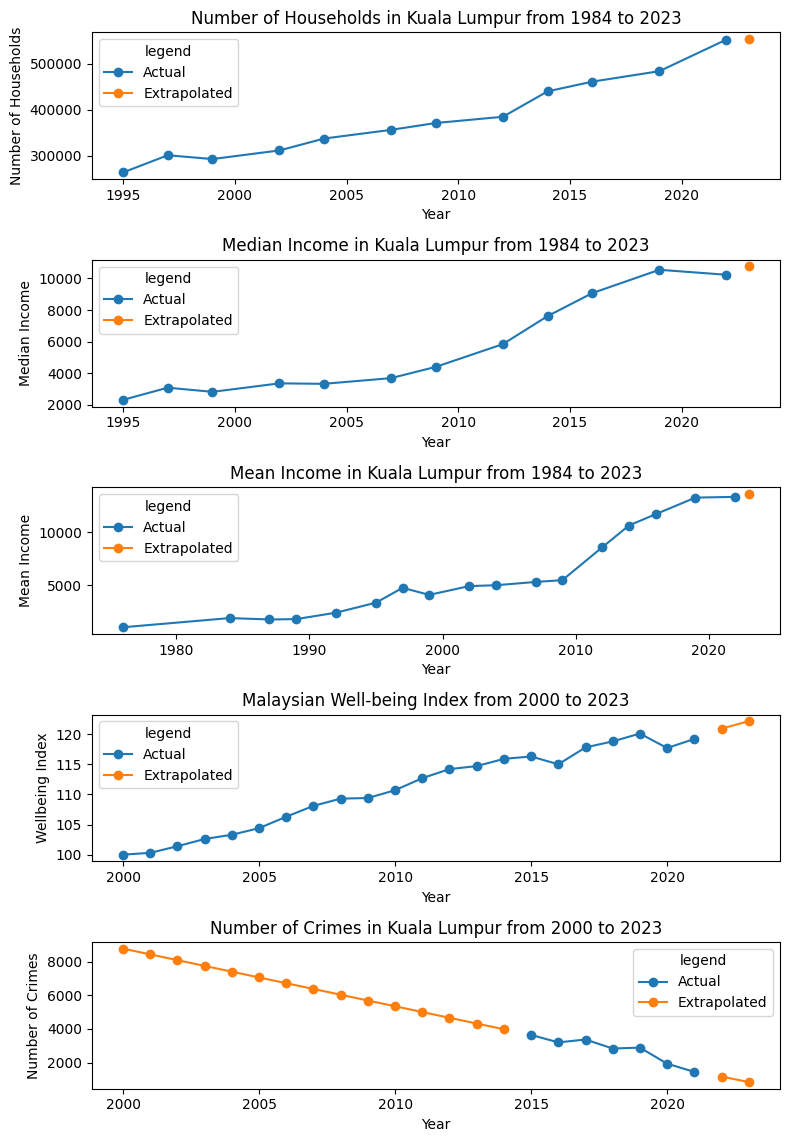

In [135]:
fig, axes = plt.subplots(nrows=5, figsize=(8, 12))
# fig.suptitle('Economic Indicators with Extrapolated Values')

df_households_extrapolated.pivot(index='year', columns='legend', values='n_households').plot(
    marker='o',
    linestyle='-',
    title='Number of Households in Kuala Lumpur from 1984 to 2023',
    xlabel='Year',
    ylabel='Number of Households',
    ax=axes[0]
)

df_median_income_extrapolated.pivot(index='year', columns='legend', values='median').plot(
    marker='o',
    linestyle='-',
    title='Median Income in Kuala Lumpur from 1984 to 2023',
    xlabel='Year',
    ylabel='Median Income',
    ax=axes[1]
)

df_mean_income_extrapolated.pivot(index='year', columns='legend', values='mean').plot(
    marker='o',
    linestyle='-',
    title='Mean Income in Kuala Lumpur from 1984 to 2023',
    xlabel='Year',
    ylabel='Mean Income',
    ax=axes[2]
)

df_wellbeing_extrapolated.pivot(index='Year', columns='legend', values='Index').plot(
    marker='o',
    linestyle='-',
    title='Malaysian Well-being Index from 2000 to 2023',
    xlabel='Year',
    ylabel='Wellbeing Index',
    ax=axes[3]
)

df_crime_combined.pivot(index='Year', columns='legend', values='Number of Crime').plot(
    marker='o',
    linestyle='-',
    title='Number of Crimes in Kuala Lumpur from 2000 to 2023',
    xlabel='Year',
    ylabel='Number of Crimes',
    ax=axes[4]
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

## Interpolating economic indicators for integration

The following economic indicators have missing years in between:
1. OPR
2. Median household income
3. Mean household income
4. Number of households

We will interpolate the missing years using linear interpolation, except for OPR.

In [89]:
df_years = pd.DataFrame({'year': [i for i in range(1995, 2024)]})
df_years.describe()

,year
count,29.000000
mean,2009.000000
std,8.514693
min,1995.000000
25%,2002.000000
50%,2009.000000
75%,2016.000000
max,2023.000000


### OPR

We do not interpolate OPR with linear interpolation because it is a rate set by the Bank Negara Malaysia. When there are no announcement of new OPR change, the OPR follows the previous OPR. Thus, we will use the previous OPR to fill in the missing years.

In [90]:
df_opr_interpolated = pd.merge(df_years, df_opr, on='year', how='left')
df_opr_interpolated

,year,date,opr_change_percentage,new_opr_percentage
0,1995,NaT,NaN,NaN
1,1996,NaT,NaN,NaN
2,1997,NaT,NaN,NaN
3,1998,1998-11-09,-0.50,7.00
4,1998,1998-10-05,-0.50,7.50
...,...,...,...,...
134,2022,2022-01-20,0,1.75
135,2023,2023-07-06,0,3.00
136,2023,2023-05-03,+0.25,3.00
137,2023,2023-03-09,0,2.75


In [91]:
for year in [2000, 2002]:
    idx = df_opr_interpolated.query(f'year == {year}').index
    df_opr_interpolated.loc[idx, 'date'] = f'{year}-01-01'
    df_opr_interpolated.loc[idx, 'opr_change_percentage'] = 0

df_opr_interpolated.query('1998 <= year <= 2005')

,year,date,opr_change_percentage,new_opr_percentage
3,1998,1998-11-09,-0.50,7.0
4,1998,1998-10-05,-0.50,7.5
5,1998,1998-09-03,-1.50,8.0
6,1998,1998-08-27,-0.50,9.5
7,1998,1998-08-10,-0.50,10.0
8,1998,1998-08-03,-0.50,10.5
9,1998,1998-02-06,+1.00,11.0
10,1999,1999-08-09,-0.50,5.5
11,1999,1999-05-03,-0.50,6.0
12,1999,1999-04-05,-0.50,6.5


In [92]:
df_opr_interpolated = df_opr_interpolated.sort_values('date').ffill()
df_opr_interpolated = df_opr_interpolated.dropna()
df_opr_interpolated.isna().sum()

year                     0
date                     0
opr_change_percentage    0
new_opr_percentage       0
dtype: int64

Missing values in OPR has been filled.

In [93]:
df_opr_interpolated.head(20)

,year,date,opr_change_percentage,new_opr_percentage
9,1998,1998-02-06,+1.00,11.0
8,1998,1998-08-03,-0.50,10.5
7,1998,1998-08-10,-0.50,10.0
6,1998,1998-08-27,-0.50,9.5
5,1998,1998-09-03,-1.50,8.0
4,1998,1998-10-05,-0.50,7.5
3,1998,1998-11-09,-0.50,7.0
12,1999,1999-04-05,-0.50,6.5
11,1999,1999-05-03,-0.50,6.0
10,1999,1999-08-09,-0.50,5.5


<Axes: title={'center': 'OPR Percentage from 1998 to 2023'}, xlabel='Year', ylabel='OPR Percentage'>

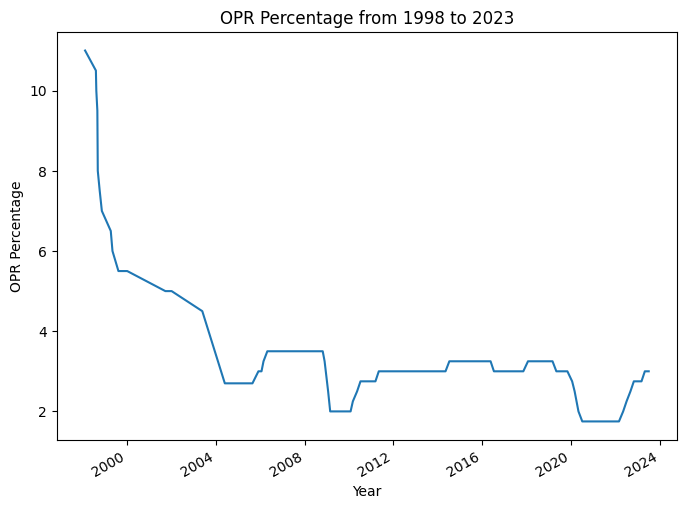

In [104]:
df_opr_interpolated.plot(
    x='date',
    y='new_opr_percentage',
    figsize=(8,6),
    title='OPR Percentage from 1998 to 2023',
    legend=False,
    xlabel='Year',
    ylabel='OPR Percentage'
)

### Median, mean household income and number of households

In [95]:
df_income_interpolated = pd.merge(df_years, df_income_extrapolated, on=['year'], how='left')
df_income_interpolated

,year,median,legend_x,mean,legend_y,n_households,legend
0,1995,2321.000000,Actual,3371.01000,Actual,264200.0,Actual
1,1996,NaN,NaN,NaN,NaN,NaN,NaN
2,1997,3090.000000,Actual,4768.00000,Actual,301600.0,Actual
3,1998,NaN,NaN,NaN,NaN,NaN,NaN
4,1999,2828.000000,Actual,4104.61000,Actual,293300.0,Actual
5,2000,NaN,NaN,NaN,NaN,NaN,NaN
6,2001,NaN,NaN,NaN,NaN,NaN,NaN
7,2002,3364.000000,Actual,4930.00000,Actual,312100.0,Actual
8,2003,NaN,NaN,NaN,NaN,NaN,NaN
9,2004,3336.000000,Actual,5011.00000,Actual,337930.0,Actual


In [97]:
df_income_interpolated = df_income_interpolated.interpolate(method='linear')
df_income_interpolated['legend'] = df_income_interpolated['legend'].fillna('Interpolated')
df_income_interpolated

C:\Users\USER\AppData\Local\Temp\ipykernel_9564\2225538361.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_income_interpolated = df_income_interpolated.interpolate(method='linear')


,year,median,legend_x,mean,legend_y,n_households,legend
0,1995,2321.000000,Actual,3371.010000,Actual,264200.000000,Actual
1,1996,2705.500000,NaN,4069.505000,NaN,282900.000000,Interpolated
2,1997,3090.000000,Actual,4768.000000,Actual,301600.000000,Actual
3,1998,2959.000000,NaN,4436.305000,NaN,297450.000000,Interpolated
4,1999,2828.000000,Actual,4104.610000,Actual,293300.000000,Actual
5,2000,3006.666667,NaN,4379.740000,NaN,299566.666667,Interpolated
6,2001,3185.333333,NaN,4654.870000,NaN,305833.333333,Interpolated
7,2002,3364.000000,Actual,4930.000000,Actual,312100.000000,Actual
8,2003,3350.000000,NaN,4970.500000,NaN,325015.000000,Interpolated
9,2004,3336.000000,Actual,5011.000000,Actual,337930.000000,Actual


The missing data for median, mean household income and number of households has been interpolated.

<Axes: title={'center': 'Household Income in Kuala Lumpur from 1995 to 2023'}, xlabel='year'>

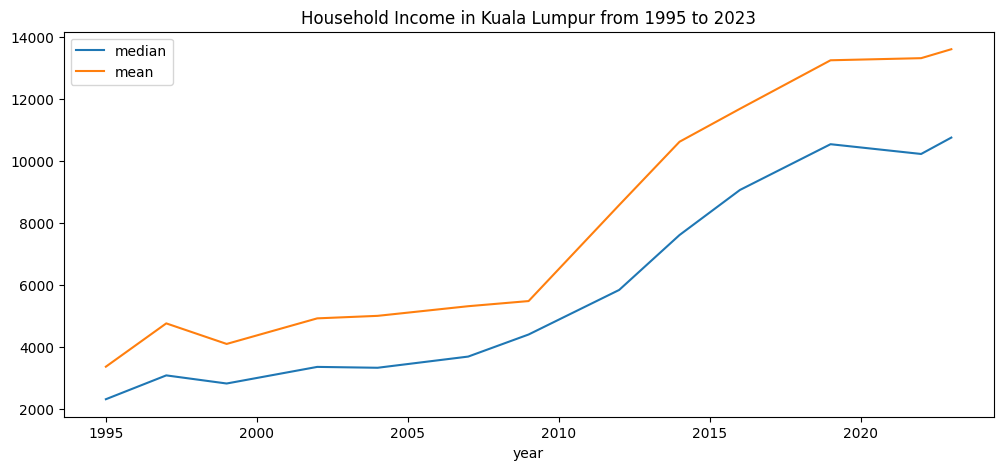

In [102]:
df_income_interpolated.plot(
    x='year',
    y=['median', 'mean'],
    figsize=(12,5),
    title='Household Income in Kuala Lumpur from 1995 to 2023'
)

<Axes: title={'center': 'Number of households in Kuala Lumpur from 1995 to 2023'}, xlabel='year'>

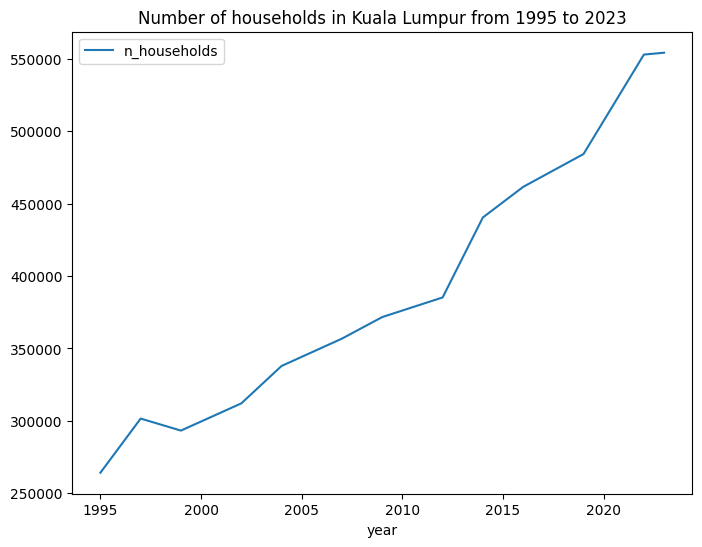

In [99]:
df_income_interpolated.plot(
    x='year',
    y='n_households',
    figsize=(8,6),
    title='Number of households in Kuala Lumpur from 1995 to 2023'
)

### Final validation for missing values in economic indicators

Let's check one more time if there are any missing values.

In [60]:
df_opr_interpolated['year'] = df_opr_interpolated['date'].dt.year

check_data_period_length(df_opr_interpolated, 'year')

Data period length is correct, we have data from 2000-2023


In [61]:
df_income_interpolated['year'] = df_income_interpolated['year'].astype('int')
for col in ['median', 'mean', 'n_households']:
    print(col)
    check_data_period_length(df_income_interpolated[['year', col]], 'year')

median
Data period length is correct, we have data from 2000-2023
mean
Data period length is correct, we have data from 2000-2023
n_households
Data period length is correct, we have data from 2000-2023


In [62]:
df_wellbeing_extrapolated = df_wellbeing_extrapolated.astype({'Year': 'int', 'Index': 'float'})
check_data_period_length(df_wellbeing_extrapolated, 'Year')

Data period length is correct, we have data from 2000-2023


In [63]:
df_crime_combined = df_crime_combined.astype({'Year': 'int', 'Number of Crime': 'float'})
check_data_period_length(df_crime_combined, 'Year')

Data period length is correct, we have data from 2000-2023


## Data integration with transactions data

Now that we have the economic indicators, we can integrate them with the transactions data:
- BNM OPR
- DOSM CPI
- DOSM household income
- DOSM number of households
- DOSM wellbeing index
- DOSM total money supply
- DOSM unemployment rate
- DOSM population
- DOSM crime rate

In [64]:
df_transactions = pd.read_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt5_multi_imputed_bayesianridge.parquet')
df_transactions.head()

,township_BANDAR BARU SRI PETALING,township_TAMAN TUN DR ISMAIL,township_DAMANSARA HEIGHTS (BUKIT DAMANSARA),township_TAMAN BUKIT MALURI,township_KEPONG BARU,township_OVERSEAS UNION GARDEN,township_HAPPY GARDEN,township_TAMAN MIDAH,township_ALAM DAMAI,township_TAMAN SRI SINAR,...,tenure_FREEHOLD,floors,rooms,land_area,built_up,price_psf,price,year,month,day
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.893189,2196.0,1130.011500,342.0,750000.0,2023.0,6.0,9.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,3.079764,753.0,1272.862928,398.0,300000.0,2023.0,6.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.5,3.232031,3197.0,1521.765384,188.0,600000.0,2023.0,5.0,29.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,3.091576,753.0,1256.558519,531.0,400000.0,2023.0,5.0,25.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.5,3.837520,4801.0,2202.912522,250.0,1200000.0,2023.0,5.0,22.0


In [65]:
ohe = joblib.load(ENCODER_MODEL_DIR / 'one_hot_encoder_township_building_type_tenure.joblib')

df_transactions = ohe.inverse_transform(df_transactions)
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day
0,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,2.893189,2196.0,1130.011500,342.0,750000.0,2023.0,6.0,9.0
1,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.079764,753.0,1272.862928,398.0,300000.0,2023.0,6.0,1.0
2,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,3.232031,3197.0,1521.765384,188.0,600000.0,2023.0,5.0,29.0
3,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.091576,753.0,1256.558519,531.0,400000.0,2023.0,5.0,25.0
4,BANDAR BARU SRI PETALING,SEMI-D,LEASEHOLD,2.5,3.837520,4801.0,2202.912522,250.0,1200000.0,2023.0,5.0,22.0


In [66]:
df_transactions.to_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt6_decoded.parquet')

### Integrate with CPI

In [67]:
df_transactions = pd.read_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt6_decoded.parquet')

In [68]:
df_transactions = df_transactions.merge(df_annual_cpi, on='year', how='left')
df_transactions = df_transactions.rename(columns={'Consumer price index (2010 = 100)': 'cpi'})
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day,cpi
0,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,2.893189,2196.0,1130.011500,342.0,750000.0,2023.0,6.0,9.0,123.075
1,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.079764,753.0,1272.862928,398.0,300000.0,2023.0,6.0,1.0,123.075
2,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,3.232031,3197.0,1521.765384,188.0,600000.0,2023.0,5.0,29.0,123.075
3,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.091576,753.0,1256.558519,531.0,400000.0,2023.0,5.0,25.0,123.075
4,BANDAR BARU SRI PETALING,SEMI-D,LEASEHOLD,2.5,3.837520,4801.0,2202.912522,250.0,1200000.0,2023.0,5.0,22.0,123.075


### Integrate with household income and number of households

In [69]:
df_transactions = df_transactions.merge(df_income_interpolated, on='year', how='left')
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day,cpi,median,mean,n_households
0,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,2.893189,2196.0,1130.011500,342.0,750000.0,2023.0,6.0,9.0,123.075,10762.874386,13613.61161,554273.0
1,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.079764,753.0,1272.862928,398.0,300000.0,2023.0,6.0,1.0,123.075,10762.874386,13613.61161,554273.0
2,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,3.232031,3197.0,1521.765384,188.0,600000.0,2023.0,5.0,29.0,123.075,10762.874386,13613.61161,554273.0
3,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.091576,753.0,1256.558519,531.0,400000.0,2023.0,5.0,25.0,123.075,10762.874386,13613.61161,554273.0
4,BANDAR BARU SRI PETALING,SEMI-D,LEASEHOLD,2.5,3.837520,4801.0,2202.912522,250.0,1200000.0,2023.0,5.0,22.0,123.075,10762.874386,13613.61161,554273.0


### Integrate with well-being index

In [70]:
df_transactions = df_transactions.merge(df_wellbeing_extrapolated, left_on='year', right_on='Year', how='left')
df_transactions = df_transactions.drop(columns=['Year'])
df_transactions = df_transactions.rename(columns={'Index': 'wellbeing_index'})
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day,cpi,median,mean,n_households,wellbeing_index
0,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,2.893189,2196.0,1130.011500,342.0,750000.0,2023.0,6.0,9.0,123.075,10762.874386,13613.61161,554273.0,122.151182
1,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.079764,753.0,1272.862928,398.0,300000.0,2023.0,6.0,1.0,123.075,10762.874386,13613.61161,554273.0,122.151182
2,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,3.232031,3197.0,1521.765384,188.0,600000.0,2023.0,5.0,29.0,123.075,10762.874386,13613.61161,554273.0,122.151182
3,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.091576,753.0,1256.558519,531.0,400000.0,2023.0,5.0,25.0,123.075,10762.874386,13613.61161,554273.0,122.151182
4,BANDAR BARU SRI PETALING,SEMI-D,LEASEHOLD,2.5,3.837520,4801.0,2202.912522,250.0,1200000.0,2023.0,5.0,22.0,123.075,10762.874386,13613.61161,554273.0,122.151182


### Integrate with money supply (M3)

In [71]:
df_transactions = df_transactions.merge(df_money[['Year', 'RM Million']], left_on='year', right_on='Year', how='left')
df_transactions = df_transactions.drop(columns=['Year'])
df_transactions = df_transactions.rename(columns={'RM Million': 'money_supply_millions'})
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day,cpi,median,mean,n_households,wellbeing_index,money_supply_millions
0,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,2.893189,2196.0,1130.011500,342.0,750000.0,2023.0,6.0,9.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7
1,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.079764,753.0,1272.862928,398.0,300000.0,2023.0,6.0,1.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7
2,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,3.232031,3197.0,1521.765384,188.0,600000.0,2023.0,5.0,29.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7
3,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.091576,753.0,1256.558519,531.0,400000.0,2023.0,5.0,25.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7
4,BANDAR BARU SRI PETALING,SEMI-D,LEASEHOLD,2.5,3.837520,4801.0,2202.912522,250.0,1200000.0,2023.0,5.0,22.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7


### Integrate with unemployment rate

In [72]:
df_transactions = df_transactions.merge(df_unemployment[['year', 'u_rate']], left_on='year', right_on='year', how='left')
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day,cpi,median,mean,n_households,wellbeing_index,money_supply_millions,u_rate
0,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,2.893189,2196.0,1130.011500,342.0,750000.0,2023.0,6.0,9.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5
1,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.079764,753.0,1272.862928,398.0,300000.0,2023.0,6.0,1.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5
2,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,3.232031,3197.0,1521.765384,188.0,600000.0,2023.0,5.0,29.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5
3,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.091576,753.0,1256.558519,531.0,400000.0,2023.0,5.0,25.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5
4,BANDAR BARU SRI PETALING,SEMI-D,LEASEHOLD,2.5,3.837520,4801.0,2202.912522,250.0,1200000.0,2023.0,5.0,22.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5


### Integrate with population

In [73]:
df_transactions = df_transactions.merge(df_population[['Year', "Total ('000)"]], left_on='year', right_on='Year', how='left')
df_transactions = df_transactions.drop(columns=['Year'])
df_transactions = df_transactions.rename(columns={"Total ('000)": 'population_thousands'})
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,month,day,cpi,median,mean,n_households,wellbeing_index,money_supply_millions,u_rate,population_thousands
0,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,2.893189,2196.0,1130.011500,342.0,750000.0,2023.0,6.0,9.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6
1,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.079764,753.0,1272.862928,398.0,300000.0,2023.0,6.0,1.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6
2,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,3.232031,3197.0,1521.765384,188.0,600000.0,2023.0,5.0,29.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6
3,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.091576,753.0,1256.558519,531.0,400000.0,2023.0,5.0,25.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6
4,BANDAR BARU SRI PETALING,SEMI-D,LEASEHOLD,2.5,3.837520,4801.0,2202.912522,250.0,1200000.0,2023.0,5.0,22.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6


### Integrate with crime rate

In [74]:
df_transactions = df_transactions.merge(df_crime_combined, left_on='year', right_on='Year', how='left')
df_transactions = df_transactions.drop(columns=['Year'])
df_transactions = df_transactions.rename(columns={'Number of Crime': 'number_of_crime'})
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,...,day,cpi,median,mean,n_households,wellbeing_index,money_supply_millions,u_rate,population_thousands,number_of_crime
0,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,2.893189,2196.0,1130.011500,342.0,750000.0,2023.0,...,9.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6,846.0
1,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.079764,753.0,1272.862928,398.0,300000.0,2023.0,...,1.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6,846.0
2,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,3.232031,3197.0,1521.765384,188.0,600000.0,2023.0,...,29.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6,846.0
3,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.091576,753.0,1256.558519,531.0,400000.0,2023.0,...,25.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6,846.0
4,BANDAR BARU SRI PETALING,SEMI-D,LEASEHOLD,2.5,3.837520,4801.0,2202.912522,250.0,1200000.0,2023.0,...,22.0,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6,846.0


### Integrate with OPR

In [75]:
df_transactions['date'] = pd.to_datetime({
    'year': df_transactions['year'],
    'month': df_transactions['month'],
    'day': df_transactions['day']
})
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,...,cpi,median,mean,n_households,wellbeing_index,money_supply_millions,u_rate,population_thousands,number_of_crime,date
0,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,1.0,2.893189,2196.0,1130.011500,342.0,750000.0,2023.0,...,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6,846.0,2023-06-09
1,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.079764,753.0,1272.862928,398.0,300000.0,2023.0,...,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6,846.0,2023-06-01
2,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.5,3.232031,3197.0,1521.765384,188.0,600000.0,2023.0,...,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6,846.0,2023-05-29
3,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,3.091576,753.0,1256.558519,531.0,400000.0,2023.0,...,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6,846.0,2023-05-25
4,BANDAR BARU SRI PETALING,SEMI-D,LEASEHOLD,2.5,3.837520,4801.0,2202.912522,250.0,1200000.0,2023.0,...,123.075,10762.874386,13613.61161,554273.0,122.151182,2319725.7,3.5,1998.6,846.0,2023-05-22


In [76]:
df_transactions = df_transactions.sort_values(by='date')
df_opr_interpolated = df_opr_interpolated.sort_values(by='date')

df_transactions = pd.merge_asof(df_transactions, df_opr_interpolated[['date', 'new_opr_percentage']], on='date', direction='backward')
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,...,median,mean,n_households,wellbeing_index,money_supply_millions,u_rate,population_thousands,number_of_crime,date,new_opr_percentage
0,HAPPY GARDEN,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,1.0,3.075262,1540.0,1111.0,107.0,165000.0,1909.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1909-05-11,NaN
1,SRI SUAJAYA,CONDOMINIUM,FREEHOLD,1.0,3.000000,969.0,969.0,136.0,131848.0,1933.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1933-10-25,NaN
2,TAMAN PANTAI DALAM FLAT,FLAT,FREEHOLD,1.0,2.000000,538.0,538.0,93.0,50000.0,1955.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1955-07-25,NaN
3,TAMAN P RAMLEE,BUNGALOW,FREEHOLD,2.0,4.000000,5500.0,1727.0,4.0,23845.0,1959.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1959-07-27,NaN
4,BLUE BOY MANSION,FLAT,FREEHOLD,1.0,3.000000,676.0,676.0,17.0,11500.0,1960.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960-11-14,NaN


In [77]:
df_transactions = df_transactions.ffill()
df_transactions = df_transactions.rename(columns={'new_opr_percentage': 'opr_percentage'})
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,...,median,mean,n_households,wellbeing_index,money_supply_millions,u_rate,population_thousands,number_of_crime,date,opr_percentage
0,HAPPY GARDEN,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,1.0,3.075262,1540.0,1111.0,107.0,165000.0,1909.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1909-05-11,NaN
1,SRI SUAJAYA,CONDOMINIUM,FREEHOLD,1.0,3.000000,969.0,969.0,136.0,131848.0,1933.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1933-10-25,NaN
2,TAMAN PANTAI DALAM FLAT,FLAT,FREEHOLD,1.0,2.000000,538.0,538.0,93.0,50000.0,1955.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1955-07-25,NaN
3,TAMAN P RAMLEE,BUNGALOW,FREEHOLD,2.0,4.000000,5500.0,1727.0,4.0,23845.0,1959.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1959-07-27,NaN
4,BLUE BOY MANSION,FLAT,FREEHOLD,1.0,3.000000,676.0,676.0,17.0,11500.0,1960.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960-11-14,NaN


In [78]:
df_transactions = df_transactions.dropna()
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,...,median,mean,n_households,wellbeing_index,money_supply_millions,u_rate,population_thousands,number_of_crime,date,opr_percentage
34996,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,128.0,129888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34997,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1007.0,1007.0,122.0,122888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34998,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,122.0,123888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
34999,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,2.000000,753.0,672.0,120.0,90000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
35000,BUKIT BANDARAYA,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,1.0,3.078282,1875.0,1126.0,180.0,338000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5


In [95]:
df_transactions = df_transactions.rename(
    columns={
        'median': 'median_income',
        'mean': 'mean_income',
        'u_rate': 'unemployment_rate',
        'number_of_crime': 'n_crimes',
        'opr_percentage': 'interest_rate'
    }
)

In [96]:
df_transactions.to_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt7_integrated.parquet')

## Validate integrated data with individual economic indicator data

### CPI

In [97]:
df_transactions['cpi'].isin(df_annual_cpi['Consumer price index (2010 = 100)']).value_counts()

cpi
True    230274
Name: count, dtype: int64

### Household income and number of households

In [98]:
df_transactions['mean_income'].isin(df_income_interpolated['mean']).value_counts()

mean_income
True    230274
Name: count, dtype: int64

In [99]:
df_transactions['median_income'].isin(df_income_interpolated['median']).value_counts()

median_income
True    230274
Name: count, dtype: int64

In [100]:
df_transactions['n_households'].isin(df_income_interpolated['n_households']).value_counts()

n_households
True    230274
Name: count, dtype: int64

### Well-being index

In [101]:
df_transactions['wellbeing_index'].isin(df_wellbeing_extrapolated['Index']).value_counts()

wellbeing_index
True    230274
Name: count, dtype: int64

### Money supply (M3)

In [102]:
df_transactions['money_supply_millions'].isin(df_money['RM Million']).value_counts()

money_supply_millions
True    230274
Name: count, dtype: int64

### Unemployment rate

In [103]:
df_transactions['unemployment_rate'].isin(df_unemployment['u_rate']).value_counts()

unemployment_rate
True    230274
Name: count, dtype: int64

### Population

In [104]:
df_transactions['population_thousands'].isin(df_population["Total ('000)"]).value_counts()

population_thousands
True    230274
Name: count, dtype: int64

### Crime rate

In [105]:
df_transactions['n_crimes'].isin(df_crime_combined['Number of Crime']).value_counts()

n_crimes
True    230274
Name: count, dtype: int64

### OPR

In [106]:
df_transactions['interest_rate'].isin(df_opr_interpolated['new_opr_percentage']).value_counts()

interest_rate
True    230274
Name: count, dtype: int64

## Concluding remarks

We have successfully integrated the economic indicators with the transactions data. The integrated data will be used for the modelling phase.

In [107]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230274 entries, 34996 to 265269
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   township               230274 non-null  category      
 1   building_type          230274 non-null  category      
 2   tenure                 230274 non-null  category      
 3   floors                 230274 non-null  float64       
 4   rooms                  230274 non-null  float64       
 5   land_area              230274 non-null  float64       
 6   built_up               230274 non-null  float64       
 7   price_psf              230274 non-null  float64       
 8   price                  230274 non-null  float64       
 9   year                   230274 non-null  float64       
 10  month                  230274 non-null  float64       
 11  day                    230274 non-null  float64       
 12  cpi                    230274 non-null  float